## Data Preparation

In [4]:
import os
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from sklearn.metrics import recall_score,precision_score,f1_score
from sklearn.model_selection import train_test_split
from geopy.distance import vincenty, geodesic

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Feb 24 14:14:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

This data preparation process is the dense and concise version described in `DataPreparation.ipynb`.

why user, trip, segement ?


is it good for time independent


is it good for the train, test, validation split


better for both CNN and RNN

`create_datesets` split the data into (user, trip, segements). Each trip contains all the segements

In [ ]:
def create_datasets_CNN():
    user = []
    label = []
    for path,directory,file in os.walk('drive/My Drive/Colab Notebooks/DPproject/numpyL/user/'):
        for ind, filename in enumerate(file):
            # sort by timestamp
            user_data = np.load('drive/My Drive/Colab Notebooks/DPproject/numpyL/user/' + filename) # shape (row, col)
            user_data_sorted = user_data[user_data[:,4].argsort()]
            #assert user_data_sorted[:,4].is_monotonic_increasing == True

            # split into trips
            trips = [] # (trip, segements, 4)
            i = 0
            for j in range(1,len(user_data_sorted)):
                if user_data_sorted[j,4] - user_data_sorted[j-1,4] <= 1200:
                    continue
                # print(np.array(user_data_sorted[i:j]))
                trips.append(user_data_sorted[i:j])
                i = j
            # print(len(trips))
            
            # split into segements for each trip
            for ind,trip in enumerate(trips):  # user -> trips -> segements
                temp_segements = []
                i = 0
                for j in range(1, len(trip)):
                    if trip[j,5] == trip[j-1,5]:
                        continue
                    temp_segements.append(trip[i:j])
                    i = j
                if(temp_segements):
                    trips[ind] = temp_segements
                else:
                    trips[ind] = [trip]
                # print("size: ",len(trips[ind]))
                # assert np.array(temp_segements).ndim == 2

            # calculate channel data
            trips_2 = []
            targets = []#np.empty((1))
            for ind,trip in enumerate(trips):
                temp_segement = []
                temp_target = []
                for ind2, segement in enumerate(trip): # segement with same mode under same trip
                    segement_4d = []

                    # drop mode 100
                    if(segement[0,5] == 100):
                        continue

                    for i in range(len(segement)-2):
                        p1 = (np.radians(segement[i,1]), np.radians(segement[i,2]))
                        p2 = (np.radians(segement[i+1,1]), np.radians(segement[i+1,2]))
                        p3 = (np.radians(segement[i+2,1]), np.radians(segement[i+2,2]))
                        dist = geodesic(p1, p2).meters
                        #print(dist)
                        t = segement[i+1,4] - segement[i,4]
                        if t == 0:
                            continue
                        speed = dist / t
                        acceleration = speed / t
                        jerk = acceleration / t

                        # Bearing Rate
                        y_1 = np.sin(p2[1] - p1[1]) * np.cos(p2[0])
                        x_1 = np.cos(p1[0])*np.sin(p2[0]) - np.sin(p1[0])*np.cos(p2[0])*np.cos(p2[1] - p1[1])
                        bearing_p1 = np.degrees(np.arctan2(y_1, x_1))

                        y_2 = np.sin(p3[1] - p2[1]) * np.cos(p3[0])
                        x_2 = np.cos(p2[0])*np.sin(p3[0]) - np.sin(p2[0])*np.cos(p3[0])*np.cos(p3[1] - p2[1])
                        bearing_p2 = np.degrees(np.arctan2(y_2, x_2))

                        bearing_rate = np.abs(bearing_p2 - bearing_p1)

                        mode = segement[i,5]
                        
                        # bus
                        if mode == 0 and (speed > 34 or acceleration > 2): 
                            continue
                        # train
                        if mode == 1 and (speed > 34 or acceleration > 3): 
                            continue
                        # walk
                        if mode == 2 and (speed > 7 or acceleration > 3): 
                            continue
                        # car
                        if mode == 3 and (speed > 50 or acceleration > 10): 
                            continue
                        # bike
                        if mode == 4 and (speed > 12 or acceleration > 3): 
                            continue
                        segement_4d.append([speed, acceleration, jerk, bearing_rate])
                        
                        if len(segement_4d) % 200 == 0:                              
                            # print(np.array(segement_4d).shape)
                            temp_segement.append(segement_4d)
                            temp_target.append(segement[0,5])
                            segement_4d = []
                            # print(np.array(segement_4d).shape)
                if len(temp_segement) > 0:
                    # print( np.array(temp_segement).shape)
                    trips_2.append(temp_segement)
                    targets.append(temp_target)
            if len(trips_2) > 0:
                user.append(trips_2)
                label.append(targets)
                # print("size(segements_4d)", np.array(trips_2).shape)
                # print("size(target)", np.array(targets).shape)
    return user, label
        


`create_datesets_RNN` split the trip every seq_size segements



In [ ]:

def create_datasets_RNN(seq_size):
    user = []
    label = []
    for path,directory,file in os.walk('drive/My Drive/Colab Notebooks/DPproject/numpyL/user/'):
        for ind, filename in enumerate(file):
            # sort by timestamp
            user_data = np.load('drive/My Drive/Colab Notebooks/DPproject/numpyL/user/' + filename) # shape (row, col)
            user_data_sorted = user_data[user_data[:,4].argsort()]
            #assert user_data_sorted[:,4].is_monotonic_increasing == True

            # split into trips
            trips = [] # (trip, segements, 4)
            i = 0
            for j in range(1,len(user_data_sorted)):
                if user_data_sorted[j,4] - user_data_sorted[j-1,4] <= 1200:
                    continue
                # print(np.array(user_data_sorted[i:j]))
                trips.append(user_data_sorted[i:j])
                i = j
            # print(len(trips))
            
            # split into segements for each trip
            for ind,trip in enumerate(trips):  # user -> trips -> segements
                temp_segements = []
                i = 0
                for j in range(1, len(trip)):
                    if trip[j,5] == trip[j-1,5]:
                        continue
                    temp_segements.append(trip[i:j])
                    i = j
                if(temp_segements):
                    trips[ind] = temp_segements
                else:
                    trips[ind] = [trip]
                # print("size: ",len(trips[ind]))
                # assert np.array(temp_segements).ndim == 2

            # calculate channel data
            trips_2 = []
            targets = []#np.empty((1))
            for ind,trip in enumerate(trips):
                temp_segement = []
                temp_target = []
                for ind2, segement in enumerate(trip): # segement with same mode under same trip
                    segement_4d = []

                    # drop mode 100
                    if(segement[0,5] == 100):
                        continue

                    for i in range(len(segement)-2):
                        p1 = (np.radians(segement[i,1]), np.radians(segement[i,2]))
                        p2 = (np.radians(segement[i+1,1]), np.radians(segement[i+1,2]))
                        p3 = (np.radians(segement[i+2,1]), np.radians(segement[i+2,2]))
                        dist = geodesic(p1, p2).meters
                        #print(dist)
                        t = segement[i+1,4] - segement[i,4]
                        if t == 0:
                            continue
                        speed = dist / t
                        acceleration = speed / t
                        jerk = acceleration / t

                        # Bearing Rate
                        y_1 = np.sin(p2[1] - p1[1]) * np.cos(p2[0])
                        x_1 = np.cos(p1[0])*np.sin(p2[0]) - np.sin(p1[0])*np.cos(p2[0])*np.cos(p2[1] - p1[1])
                        bearing_p1 = np.degrees(np.arctan2(y_1, x_1))

                        y_2 = np.sin(p3[1] - p2[1]) * np.cos(p3[0])
                        x_2 = np.cos(p2[0])*np.sin(p3[0]) - np.sin(p2[0])*np.cos(p3[0])*np.cos(p3[1] - p2[1])
                        bearing_p2 = np.degrees(np.arctan2(y_2, x_2))

                        bearing_rate = np.abs(bearing_p2 - bearing_p1)

                        mode = segement[i,5]
                        
                        # bus
                        if mode == 0 and (speed > 34 or acceleration > 2): 
                            continue
                        # train
                        if mode == 1 and (speed > 34 or acceleration > 3): 
                            continue
                        # walk
                        if mode == 2 and (speed > 7 or acceleration > 3): 
                            continue
                        # car
                        if mode == 3 and (speed > 50 or acceleration > 10): 
                            continue
                        # bike
                        if mode == 4 and (speed > 12 or acceleration > 3): 
                            continue
                        segement_4d.append([speed, acceleration, jerk, bearing_rate])
                        
                        if len(segement_4d) % 200 == 0:                               # from 200 -> 50
                            # print(np.array(segement_4d).shape)
                            temp_segement.append(segement_4d)
                            temp_target.append(segement[0,5])
                            segement_4d = []
                            # print(np.array(segement_4d).shape)
                        if len(temp_segement) >= seq_size:
                            # print( np.array(temp_segement).shape)
                            trips_2.append(temp_segement)
                            targets.append(temp_target)
                            temp_segement = []
                            temp_target = []
            #if len(trips_2) > 0:
                user.append(trips_2)
                label.append(targets)
                # print("size(trips)", np.array(trips_2).shape)
                # print("size(target)", np.array(targets).shape)
            else:
                print("-1")
    return user, label
        


In [ ]:
userCNN, labelCNN = create_datasets_CNN()

In [ ]:
userRNN4, labelRNN4 = create_datasets_RNN(seq_size = 4)

In [ ]:
userRNN6, labelRNN6 = create_datasets_RNN(seq_size = 6)

In [ ]:
userRNN8, labelRNN8 = create_datasets_RNN(seq_size = 8)

In [ ]:
userRNN10, labelRNN10 = create_datasets_RNN(seq_size = 10)

In [ ]:
userRNN12, labelRNN12 = create_datasets_RNN(seq_size = 12)

In [ ]:
# # dump CNN dataset
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userCNN.pickle', 'wb')
pickle.dump(userCNN, u)
l = open("/content/drive/My Drive/Colab Notebooks/DPproject/labelCNN.pickle", "wb")
pickle.dump(labelCNN, l)



In [ ]:
# dump RNN dateset
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN4.pickle', 'wb')
pickle.dump(userRNN4, u)
l = open("/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN4.pickle", "wb")
pickle.dump(labelRNN4, l)

In [ ]:
# dump RNN dateset
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN6.pickle', 'wb')
pickle.dump(userRNN6, u)
l = open("/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN6.pickle", "wb")
pickle.dump(labelRNN6, l)

In [ ]:
# dump RNN dateset
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN8.pickle', 'wb')
pickle.dump(userRNN8, u)
l = open("/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN8.pickle", "wb")
pickle.dump(labelRNN8, l)

In [ ]:
# dump RNN dateset
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN10.pickle', 'wb')
pickle.dump(userRNN10, u)
l = open("/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN10.pickle", "wb")
pickle.dump(labelRNN10, l)

In [ ]:
# dump RNN dateset
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN12.pickle', 'wb')
pickle.dump(userRNN12, u)
l = open("/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN12.pickle", "wb")
pickle.dump(labelRNN12, l)

In [1]:
# Restore CNN
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userCNN.pickle', 'rb')
userCNN = pickle.load(u)
l = open('/content/drive/My Drive/Colab Notebooks/DPproject/labelCNN.pickle', 'rb')
labelCNN = pickle.load(l)

# Restore RNN4
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN4.pickle', 'rb')
userRNN4 = pickle.load(u)
l = open('/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN4.pickle', 'rb')
labelRNN4 = pickle.load(l)

# Restore RNN6
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN6.pickle', 'rb')
userRNN6 = pickle.load(u)
l = open('/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN6.pickle', 'rb')
labelRNN6 = pickle.load(l)

# Restore RNN8
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN8.pickle', 'rb')
userRNN8 = pickle.load(u)
l = open('/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN8.pickle', 'rb')
labelRNN8 = pickle.load(l)

# Restore RNN10
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN10.pickle', 'rb')
userRNN10 = pickle.load(u)
l = open('/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN10.pickle', 'rb')
labelRNN10 = pickle.load(l)

# Restore RNN12
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN12.pickle', 'rb')
userRNN12 = pickle.load(u)
l = open('/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN12.pickle', 'rb')
labelRNN12 = pickle.load(l)

FileNotFoundError: ignored

In [2]:
print('user')

print(len(userRNN4))
print(len(userRNN6))
print(len(userRNN8))
print(len(userRNN10))
print(len(userRNN12))

print('label')
print(len(labelRNN4))
print(len(labelRNN6))
print(len(labelRNN8))
print(len(labelRNN10))
print(len(labelRNN12))

user


NameError: ignored

0. BUS
1. Train & Subway
2. Walk & Run
3. Car & Taxi & Motocycle
4. Bike?
100. others


In [ ]:
# for i in user:
#     for j in i:
#         print(np.array(j).shape)
for i in userRNN10:
    print(np.array(i).shape)
# print(np.array(user[5]).shape)
# print(len(user[1][0]))

(11, 10, 200, 4)
(9, 10, 200, 4)
(26, 10, 200, 4)
(1, 10, 200, 4)
(162, 10, 200, 4)
(1, 10, 200, 4)
(1, 10, 200, 4)
(1, 10, 200, 4)
(1, 10, 200, 4)
(25, 10, 200, 4)
(58, 10, 200, 4)
(56, 10, 200, 4)
(27, 10, 200, 4)
(26, 10, 200, 4)
(7, 10, 200, 4)
(8, 10, 200, 4)
(3, 10, 200, 4)
(9, 10, 200, 4)
(21, 10, 200, 4)
(4, 10, 200, 4)
(7, 10, 200, 4)
(35, 10, 200, 4)
(1, 10, 200, 4)
(1, 10, 200, 4)
(2, 10, 200, 4)
(10, 10, 200, 4)
(5, 10, 200, 4)
(1, 10, 200, 4)


In [ ]:
for i in userRNN4:
    print(np.array(i).shape)

(62, 4, 200, 4)
(4, 4, 200, 4)
(1, 4, 200, 4)
(42, 4, 200, 4)
(86, 4, 200, 4)
(2, 4, 200, 4)
(10, 4, 200, 4)
(463, 4, 200, 4)
(1, 4, 200, 4)
(2, 4, 200, 4)
(2, 4, 200, 4)
(29, 4, 200, 4)
(7, 4, 200, 4)
(1, 4, 200, 4)
(185, 4, 200, 4)
(256, 4, 200, 4)
(353, 4, 200, 4)
(125, 4, 200, 4)
(162, 4, 200, 4)
(34, 4, 200, 4)
(26, 4, 200, 4)
(17, 4, 200, 4)
(61, 4, 200, 4)
(118, 4, 200, 4)
(24, 4, 200, 4)
(81, 4, 200, 4)
(180, 4, 200, 4)
(11, 4, 200, 4)
(34, 4, 200, 4)
(14, 4, 200, 4)
(125, 4, 200, 4)
(31, 4, 200, 4)
(12, 4, 200, 4)


In [ ]:
for i in userRNN6:
    print(np.array(i).shape)

(29, 6, 200, 4)
(1, 6, 200, 4)
(22, 6, 200, 4)
(49, 6, 200, 4)
(4, 6, 200, 4)
(293, 6, 200, 4)
(1, 6, 200, 4)
(1, 6, 200, 4)
(16, 6, 200, 4)
(3, 6, 200, 4)
(101, 6, 200, 4)
(133, 6, 200, 4)
(166, 6, 200, 4)
(67, 6, 200, 4)
(77, 6, 200, 4)
(17, 6, 200, 4)
(13, 6, 200, 4)
(8, 6, 200, 4)
(24, 6, 200, 4)
(68, 6, 200, 4)
(13, 6, 200, 4)
(42, 6, 200, 4)
(96, 6, 200, 4)
(2, 6, 200, 4)
(14, 6, 200, 4)
(8, 6, 200, 4)
(48, 6, 200, 4)
(13, 6, 200, 4)
(3, 6, 200, 4)


In [ ]:
for i in userRNN8:
    print(np.array(i).shape)

(18, 8, 200, 4)
(15, 8, 200, 4)
(32, 8, 200, 4)
(1, 8, 200, 4)
(204, 8, 200, 4)
(1, 8, 200, 4)
(1, 8, 200, 4)
(1, 8, 200, 4)
(1, 8, 200, 4)
(41, 8, 200, 4)
(80, 8, 200, 4)
(102, 8, 200, 4)
(40, 8, 200, 4)
(46, 8, 200, 4)
(11, 8, 200, 4)
(9, 8, 200, 4)
(5, 8, 200, 4)
(16, 8, 200, 4)
(38, 8, 200, 4)
(6, 8, 200, 4)
(15, 8, 200, 4)
(59, 8, 200, 4)
(1, 8, 200, 4)
(10, 8, 200, 4)
(3, 8, 200, 4)
(24, 8, 200, 4)
(7, 8, 200, 4)
(1, 8, 200, 4)


In [ ]:
for i in userRNN12:
    print(np.array(i).shape)

(5, 12, 200, 4)
(5, 12, 200, 4)
(17, 12, 200, 4)
(1, 12, 200, 4)
(128, 12, 200, 4)
(1, 12, 200, 4)
(15, 12, 200, 4)
(40, 12, 200, 4)
(32, 12, 200, 4)
(21, 12, 200, 4)
(19, 12, 200, 4)
(7, 12, 200, 4)
(6, 12, 200, 4)
(1, 12, 200, 4)
(3, 12, 200, 4)
(13, 12, 200, 4)
(2, 12, 200, 4)
(3, 12, 200, 4)
(27, 12, 200, 4)
(1, 12, 200, 4)
(2, 12, 200, 4)
(6, 12, 200, 4)
(2, 12, 200, 4)
(1, 12, 200, 4)


In [ ]:
np.unique(labelCNN)

array([list([[0.0, 0.0]]),
       list([[0.0, 0.0], [0.0], [0.0], [2.0, 2.0], [0.0, 0.0, 0.0], [2.0, 2.0, 2.0, 2.0, 2.0, 2.0], [0.0, 2.0, 2.0, 2.0], [0.0, 0.0, 0.0], [2.0], [2.0], [0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [2.0, 2.0, 2.0, 2.0, 2.0], [3.0], [0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0], [2.0, 0.0], [0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0], [2.0, 2.0], [3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 0.0, 0.0, 0.0], [2.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0], [2.0], [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0], [0.0, 0.0, 0.0], [2.0, 2.0, 2.0], [0.0, 0.0, 0.0, 0.0], [0.0], [2.0, 2.0, 2.0, 2.0, 2.

## ## Define a Recurrent Neural Network seq_6


In [ ]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

#from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

Build the network based on the <span class="mark">yellow colored parameters</span>

![image.png](attachment:image.png)

In [ ]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


Running GPU.


### define train, validation, test set

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# split to train, valid, test set

x_remain_ind, x_test_ind, y_remain_ind, y_test_ind = train_test_split(list(range(len(userRNN6))),list(range(len(labelRNN6))),test_size=0.2)
x_train_ind, x_valid_ind, y_train_ind, y_valid_ind = train_test_split(x_remain_ind,y_remain_ind,test_size =0.375)

print(x_train_ind)
print(x_valid_ind)
print(x_test_ind)
print(y_train_ind)
print(y_valid_ind)
print(y_test_ind)

print(f'We have {len(x_train_ind)} users in the training set')
print(f'We have {len(x_valid_ind)} users in the validation set.')

def flatten_user_channel(x):
    return [[[c for p in sege for c in p] for sege in trip] for user in x for trip in user]
def flatten_user(x):
    return [trip for user in x for trip in user]

print(f'We have {len(x_test_ind)} users in the test set.')
x_train =np.array(flatten_user_channel([userRNN6[i] for i in x_train_ind]))
x_valid = np.array(flatten_user_channel([userRNN6[i] for i in x_valid_ind]))
x_test = np.array(flatten_user_channel([userRNN6[i] for i in x_test_ind]))

y_train = np.array(flatten_user([labelRNN6[i] for i in y_train_ind]))
y_valid = np.array(flatten_user([labelRNN6[i] for i in y_valid_ind]))
y_test = np.array(flatten_user([labelRNN6[i] for i in y_test_ind]))

print("Total segments of x_train",sum([np.array(i).shape[0] for i in x_train]), "*",  np.array(x_train[0]).shape)
print("Total segments of y_train",sum([np.array(i).shape[0] for i in y_train]), "*", np.array(y_train[0]).shape)

print("Total segments of x_valid",sum([np.array(i).shape[0] for i in x_valid]), "*",  np.array(x_valid[0]).shape)
print("Total segments of y_valid",sum([np.array(i).shape[0] for i in y_valid]),"*", np.array(y_valid[0]).shape)

print("Total segments of x_test",sum([np.array(i).shape[0] for i in x_test]), "*",  np.array(x_test[0]).shape)
print("Total segments of y_test",sum([np.array(i).shape[0] for i in y_test]), "*", np.array(y_test[0]).shape)

[22, 26, 3, 0, 7, 18, 14, 4, 6, 16, 17, 25, 13, 12]
[24, 11, 2, 1, 28, 10, 15, 20, 27]
[19, 9, 5, 8, 23, 21]
[22, 26, 3, 0, 7, 18, 14, 4, 6, 16, 17, 25, 13, 12]
[24, 11, 2, 1, 28, 10, 15, 20, 27]
[19, 9, 5, 8, 23, 21]
We have 14 users in the training set
We have 9 users in the validation set.
We have 6 users in the test set.
Total segments of x_train 3546 * (6, 800)
Total segments of y_train 3546 * (6,)
Total segments of x_valid 1902 * (6, 800)
Total segments of y_valid 1902 * (6,)
Total segments of x_test 2544 * (6, 800)
Total segments of y_test 2544 * (6,)


batch_size = 10
[12, 1, 0, 14, 6, 3, 20, 17, 16, 10, 11, 13, 21]
[5, 4, 2, 22, 15]
[18, 7, 8, 9, 19]

batch_size = 20
[9, 18, 13, 20, 1, 22, 12, 10, 17, 0, 4, 16, 21]
[11, 19, 8, 2, 5]
[15, 14, 3, 6, 7]

1. Batch size / shuffle
2. LSTM / GRU
3. Confusion Matrix



In [ ]:
np.array(x_train).shape

(591, 6, 800)

### Define Network

In [ ]:
# Hyper-parameters
input_size = 800
hidden_size = 5

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.rnn = nn.LSTM(input_size, hidden_size = hidden_size, num_layers = 3, bidirectional = True, bias = False, batch_first = True ) 
        #discuss bidirectional and compare with Gru and LSTM
        self.dropout = nn.Dropout2d(p = 0.7)
        self.layernorm = nn.LayerNorm([2* hidden_size])
        self.l_out1 = nn.Linear(in_features=2*hidden_size,
                            out_features= 10,
                            bias=False)
        self.l_out2 = nn.Linear(in_features=10,
                            out_features= 5,
                            bias=False)

    def forward(self, x):

        # RNN returns output and last hidden state
        # print("1    ", x.shape)
        x, h = self.rnn(x)

        x = self.layernorm(x)
        # print("2    ", x.shape)
        # Flatten output for feed-forward layer
        x = relu(x.view(-1, 2 * self.rnn.hidden_size))
        # print("3    ", x.shape)
        # x = self.dropout(x)
        # Output layer
        # x = self.l_out1(x)
        x = relu(self.l_out1(x))
        # print("4    ", x.shape)
        x = relu(self.l_out2(x))

        
        return x

In [ ]:
# Initialize a new network
net = Net()
if use_cuda:
    net.cuda()
print(net)

# Define a loss function and optimizer for this problem
y_train_mode_spread = [sege for trip in y_train for sege in trip]
print(y_train_mode_spread)
unique, counts = np.unique(y_train_mode_spread, return_counts=True)
print(unique, counts)
weights = torch.FloatTensor(1/counts * np.min(counts)).cuda()
print(weights)
criterion = nn.CrossEntropyLoss(weight= weights)
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr =0.001, betas=(0.9, 0.999),eps = 1e-08, weight_decay=0.0001 ) # early stop/ auto decay
#optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=0.0001 ) # early stop/ auto decay

#ADAM lr=0.001, wc=0.0001


Net(
  (rnn): LSTM(800, 5, num_layers=3, bias=False, batch_first=True, bidirectional=True)
  (dropout): Dropout2d(p=0.7, inplace=False)
  (layernorm): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
  (l_out1): Linear(in_features=10, out_features=10, bias=False)
  (l_out2): Linear(in_features=10, out_features=5, bias=False)
)
[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3

In [ ]:
np.sum([np.product(x.detach().cpu().numpy().shape) for x in net.parameters()])

33570

In [ ]:
np.array(x_train[4]).shape

(6, 800)

### define criterion

In [ ]:
print(x_valid)

[[[5.39134088e-02 1.34783522e-02 3.36958805e-03 ... 1.45089556e-02
   7.25447779e-03 1.90197803e+01]
  [2.23854104e-01 1.11927052e-01 5.59635261e-02 ... 5.02330906e-02
   2.51165453e-02 3.15540583e+01]
  [1.18452387e-01 5.92261936e-02 2.96130968e-02 ... 6.64511820e-02
   3.32255910e-02 1.46480600e+00]
  [1.51699612e-01 7.58498060e-02 3.79249030e-02 ... 8.29806189e-02
   4.14903095e-02 4.12814497e+00]
  [1.37542983e-01 6.87714917e-02 3.43857458e-02 ... 6.29091284e-02
   3.14545642e-02 5.33716447e+00]
  [1.04018370e-01 5.20091849e-02 2.60045924e-02 ... 1.06846948e-01
   5.34234740e-02 1.59962774e+00]]

 [[3.39168976e-02 1.69584488e-02 8.47922441e-03 ... 5.61355995e-02
   2.80677998e-02 1.52870179e+01]
  [7.81874014e-03 3.90937007e-03 1.95468504e-03 ... 2.61911532e-02
   1.30955766e-02 9.99227343e+00]
  [4.90328610e-02 2.45164305e-02 1.22582152e-02 ... 1.41545640e-01
   7.07728198e-02 1.63678897e+00]
  [2.94484588e-01 1.47242294e-01 7.36211471e-02 ... 5.82993818e-02
   2.91496909e-02 1.20

### Train the network

Epoch  1 : Train Loss 0.010914 , Validation Loss 0.010214, Train acc 0.283854, Valid acc 0.298828


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch 11 : Train Loss 0.010587 , Validation Loss 0.010256, Train acc 0.380534, Valid acc 0.382161
Epoch 21 : Train Loss 0.010335 , Validation Loss 0.010259, Train acc 0.385091, Valid acc 0.398438
Epoch 31 : Train Loss 0.010016 , Validation Loss 0.010282, Train acc 0.402995, Valid acc 0.393229
Epoch 41 : Train Loss 0.009640 , Validation Loss 0.010408, Train acc 0.423177, Valid acc 0.392578
Epoch 51 : Train Loss 0.009196 , Validation Loss 0.010559, Train acc 0.456380, Valid acc 0.380208
Epoch 61 : Train Loss 0.008691 , Validation Loss 0.010807, Train acc 0.499674, Valid acc 0.378255
Epoch 71 : Train Loss 0.008165 , Validation Loss 0.011116, Train acc 0.537109, Valid acc 0.391927
Epoch 81 : Train Loss 0.007618 , Validation Loss 0.011605, Train acc 0.570638, Valid acc 0.398438
Epoch 91 : Train Loss 0.007170 , Validation Loss 0.011982, Train acc 0.594727, Valid acc 0.389974
Epoch 101 : Train Loss 0.006743 , Validation Loss 0.012543, Train acc 0.623047, Valid acc 0.392578
Epoch 111 : Train L

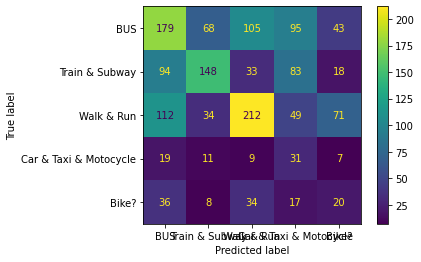

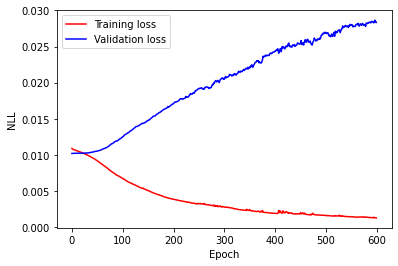

In [ ]:
batch_size = 128
num_epochs = 600
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
training_loss = []
validation_loss = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    net.train()
    for i in range(num_batches_train):
        slc = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slc]))
        # print(x_batch.shape)
        output = net(x_batch.float().cuda())
        
        # compute gradients given loss
        y_batch = Variable(torch.from_numpy(y_train[slc]).long()).reshape(-1)
        # print(output.shape, y_batch.shape)
        loss = criterion(output, y_batch.cuda())
        optimizer.zero_grad()

        # for item in net.named_parameters():
        #     h = item[1].register_hook(lambda grad: print(grad))
        loss.backward()

        # prevent gradient exploding
        torch.nn.utils.clip_grad_norm(net.parameters(), 0.25)
        optimizer.step()
        
        # Update loss
        epoch_training_loss += loss.detach().cpu().numpy()

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    with torch.no_grad(): # 禁用梯度计算
        for i in range(num_batches_train):
            slc = get_slice(i, batch_size)
            # print(slc)
            x_batch = Variable(torch.from_numpy(x_train[slc]))
            
            output = net(x_batch.float().cuda()) # [seq, batch, num_direction*hidden_size]
            # print(output.shape)
            preds = torch.max(output, 1)[1]
            # print(preds.shape)
            # print('preds:', preds)
            
            train_targs += list(y_train[slc].reshape(-1))
            train_preds += list(preds.cpu().data.numpy())

    
    ### Evaluate validation
    val_preds, val_targs = [], []
    with torch.no_grad(): # 禁用梯度计算
        for i in range(num_batches_valid):
            slc = get_slice(i, batch_size)
            x_batch = Variable(torch.from_numpy(x_valid[slc]))
            # print(x_batch)
            output = net(x_batch.float().cuda())
            # print(output)
            preds = torch.max(output, 1)[1]
            # print('preds:', preds)
            
            val_preds += list(preds.cpu().data.numpy())
            val_targs += list(y_valid[slc].reshape(-1))
            # Compute loss
            loss = criterion(output, y_batch.cuda())
            # Update loss
            epoch_validation_loss += loss.detach().cpu().numpy()

    train_acc_cur = accuracy_score(train_targs, train_preds)

    # print(val_targs)
    # print(val_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(x_train))
    validation_loss.append(epoch_validation_loss/len(x_valid))
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Validation Loss %f, Train acc %f, Valid acc %f" % (
                epoch+1, training_loss[-1], validation_loss[-1], train_acc_cur, valid_acc_cur))
        
    if epoch == num_epochs-1:
        print(val_targs, val_preds)
        cm = confusion_matrix(val_targs, val_preds, labels = [0, 1, 2, 3, 4])
        ConfusionMatrixDisplay(cm, display_labels= ['BUS','Train & Subway', 'Walk & Run', 'Car & Taxi & Motocycle', 'Bike?']).plot(values_format = 'd')
        print(classification_report(val_targs, val_preds, target_names = ['BUS','Train & Subway', 'Walk & Run', 'Car & Taxi & Motocycle', 'Bike?']))


# Plot training and validation loss
import matplotlib.pyplot as plt
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()


[0.2838541666666667, 0.2877604166666667, 0.302734375, 0.3229166666666667, 0.3372395833333333, 0.3483072916666667, 0.359375, 0.3649088541666667, 0.37109375, 0.3759765625, 0.3805338541666667, 0.3792317708333333, 0.3792317708333333, 0.3802083333333333, 0.3834635416666667, 0.3834635416666667, 0.3850911458333333, 0.3828125, 0.3828125, 0.3824869791666667, 0.3850911458333333, 0.384765625, 0.3863932291666667, 0.3863932291666667, 0.3909505208333333, 0.3942057291666667, 0.3981119791666667, 0.4010416666666667, 0.4026692708333333, 0.4033203125, 0.4029947916666667, 0.4059244791666667, 0.4069010416666667, 0.4072265625, 0.4072265625, 0.4095052083333333, 0.4130859375, 0.4140625, 0.4150390625, 0.4192708333333333, 0.4231770833333333, 0.4208984375, 0.4228515625, 0.4264322916666667, 0.4293619791666667, 0.431640625, 0.4375, 0.4417317708333333, 0.447265625, 0.4514973958333333, 0.4563802083333333, 0.4606119791666667, 0.4664713541666667, 0.4690755208333333, 0.4749348958333333, 0.4775390625, 0.4847005208333333

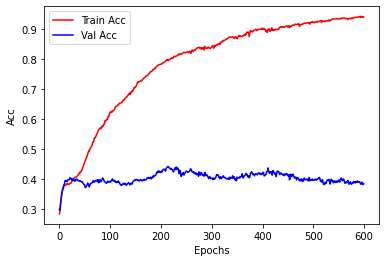


Test set Acc:  0.524371


In [ ]:
import matplotlib.pyplot as plt

epoch = np.arange(len(train_acc))
plt.figure()
print(train_acc)
print(valid_acc)
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Acc', 'Val Acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()

### Evaluate test set
x_batch = Variable(torch.from_numpy(x_test))
output = net(x_batch.float().cuda())
preds = torch.max(output, 1)[1]
print("\nTest set Acc:  %f" % (accuracy_score(list(y_test.reshape(-1)), list(preds.cpu().data.numpy()))))

In [ ]:
import os
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from sklearn.metrics import recall_score,precision_score,f1_score
from sklearn.model_selection import train_test_split
from geopy.distance import vincenty, geodesic

Check what GPU is used.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Jan  4 19:55:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    32W / 250W |    915MiB / 16280MiB |      1%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Define a Recurrent Neural Network seq_8

> Indented block



In [5]:
# Restore RNN8
u = open('/content/drive/My Drive/s182190/data/Geolife/userRNN8.pickle', 'rb')
userRNN8 = pickle.load(u)
l = open('/content/drive/My Drive/s182190/data/Geolife/labelRNN8.pickle', 'rb')
labelRNN8 = pickle.load(l)

In [6]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

#from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

Build the network based on the <span class="mark">yellow colored parameters</span>

![image.png](attachment:image.png)

In [7]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


Running GPU.


### define train, validation, test set

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# split to train, valid, test set

x_remain_ind, x_test_ind, y_remain_ind, y_test_ind = train_test_split(list(range(len(userRNN8))),list(range(len(labelRNN8))),test_size=0.2, random_state = 1)
x_train_ind, x_valid_ind, y_train_ind, y_valid_ind = train_test_split(x_remain_ind,y_remain_ind,test_size =0.375, random_state = 1)



print(x_train_ind)
print(x_valid_ind)
print(x_test_ind)
print(y_train_ind)
print(y_valid_ind)
print(y_test_ind)

print(f'We have {len(x_train_ind)} users in the training set')
print(f'We have {len(x_valid_ind)} users in the validation set.')

def flatten_user_channel(x):
    return [[[c for p in sege for c in p] for sege in trip] for user in x for trip in user]
def flatten_user(x):
    return [trip for user in x for trip in user]

print(f'We have {len(x_test_ind)} users in the test set.')
x_train =np.array(flatten_user_channel([userRNN8[i] for i in x_train_ind]))
x_valid = np.array(flatten_user_channel([userRNN8[i] for i in x_valid_ind]))
x_test = np.array(flatten_user_channel([userRNN8[i] for i in x_test_ind]))

y_train = np.array(flatten_user([labelRNN8[i] for i in y_train_ind]))
y_valid = np.array(flatten_user([labelRNN8[i] for i in y_valid_ind]))
y_test = np.array(flatten_user([labelRNN8[i] for i in y_test_ind]))

print("Total segments of x_train",sum([np.array(i).shape[0] for i in x_train]), "*",  np.array(x_train[0]).shape)
print("Total segments of y_train",sum([np.array(i).shape[0] for i in y_train]), "*", np.array(y_train[0]).shape)

print("Total segments of x_valid",sum([np.array(i).shape[0] for i in x_valid]), "*",  np.array(x_valid[0]).shape)
print("Total segments of y_valid",sum([np.array(i).shape[0] for i in y_valid]),"*", np.array(y_valid[0]).shape)

print("Total segments of x_test",sum([np.array(i).shape[0] for i in x_test]), "*",  np.array(x_test[0]).shape)
print("Total segments of y_test",sum([np.array(i).shape[0] for i in y_test]), "*", np.array(y_test[0]).shape)

[9, 6, 18, 10, 15, 22, 5, 11, 7, 13, 16, 1, 23]
[12, 26, 4, 0, 8, 27, 25, 2, 21]
[24, 17, 19, 20, 14, 3]
[9, 6, 18, 10, 15, 22, 5, 11, 7, 13, 16, 1, 23]
[12, 26, 4, 0, 8, 27, 25, 2, 21]
[24, 17, 19, 20, 14, 3]
We have 13 users in the training set
We have 9 users in the validation set.
We have 6 users in the test set.
Total segments of x_train 2800 * (8, 800)
Total segments of y_train 2800 * (8,)
Total segments of x_valid 3088 * (8, 800)
Total segments of y_valid 3088 * (8,)
Total segments of x_test 416 * (8, 800)
Total segments of y_test 416 * (8,)


batch_size = 10
[12, 1, 0, 14, 6, 3, 20, 17, 16, 10, 11, 13, 21]
[5, 4, 2, 22, 15]
[18, 7, 8, 9, 19]

batch_size = 20
[9, 18, 13, 20, 1, 22, 12, 10, 17, 0, 4, 16, 21]
[11, 19, 8, 2, 5]
[15, 14, 3, 6, 7]

1. Batch size / shuffle
2. LSTM / GRU
3. Confusion Matrix



In [ ]:
np.array(x_train).shape

(350, 8, 800)

### Define Network

In [ ]:
# Hyper-parameters
input_size = 800
hidden_size = 5

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.rnn = nn.LSTM(input_size, hidden_size = hidden_size, num_layers = 2, bidirectional = True, bias = False, batch_first = True ) 
        #discuss bidirectional and compare with Gru and LSTM
        self.dropout = nn.Dropout2d(p = 0.7)
        self.layernorm = nn.LayerNorm([2* hidden_size])
        self.l_out1 = nn.Linear(in_features=2*hidden_size,
                            out_features= 10,
                            bias=False)
        self.l_out2 = nn.Linear(in_features=10,
                            out_features= 5,
                            bias=False)

    def forward(self, x):

        # RNN returns output and last hidden state
        # print("1    ", x.shape)
        x, h = self.rnn(x)

        x = self.layernorm(x)
        # print("2    ", x.shape)
        # Flatten output for feed-forward layer
        x = relu(x.view(-1, 2 * self.rnn.hidden_size))
        # print("3    ", x.shape)
        # x = self.dropout(x)
        # Output layer
        # x = self.l_out1(x)
        x = relu(self.l_out1(x))
        # print("4    ", x.shape)
        x = relu(self.l_out2(x))


        
        return x

In [ ]:
# Initialize a new network
net = Net()
if use_cuda:
    net.cuda()
print(net)

# Define a loss function and optimizer for this problem
y_train_mode_spread = [sege for trip in y_train for sege in trip]
print(y_train_mode_spread)
unique, counts = np.unique(y_train_mode_spread, return_counts=True)
print(unique, counts)
weights = torch.FloatTensor(1/counts * np.min(counts)).cuda()
print(weights)
criterion = nn.CrossEntropyLoss(weight= weights)
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr =0.001, betas=(0.9, 0.999),eps = 1e-08, weight_decay=0.0001 ) # early stop/ auto decay
#optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=0.0001 ) # early stop/ auto decay

#ADAM lr=0.001, wc=0.0001


Net(
  (rnn): LSTM(800, 5, num_layers=2, bias=False, batch_first=True, bidirectional=True)
  (dropout): Dropout2d(p=0.7, inplace=False)
  (layernorm): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
  (l_out1): Linear(in_features=10, out_features=10, bias=False)
  (l_out2): Linear(in_features=10, out_features=5, bias=False)
)
[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2

In [ ]:
np.sum([np.product(x.detach().cpu().numpy().shape) for x in net.parameters()])

32970

In [ ]:
np.array(x_train[4]).shape

(8, 800)

### define criterion

In [ ]:
print(x_valid)

[[[1.87423161e-02 3.74846321e-03 7.49692642e-04 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.64183353e-03
   5.28366706e-04 2.44447867e+01]
  [6.69010855e-02 2.23003618e-02 7.43345395e-03 ... 1.61357045e-02
   8.06785227e-03 3.01248839e+02]
  ...
  [6.77634737e-02 3.38817369e-02 1.69408684e-02 ... 5.85424960e-02
   2.92712480e-02 4.57910200e+00]
  [2.62475773e-01 1.31237887e-01 6.56189433e-02 ... 2.00013078e-02
   1.00006539e-02 1.71293546e+01]
  [4.53394831e-02 2.26697416e-02 1.13348708e-02 ... 2.43394270e-02
   1.21697135e-02 1.32061158e+01]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.18218704e-01
   5.91093522e-02 2.52346439e+00]
  [2.26919434e-01 1.13459717e-01 5.67298585e-02 ... 1.26303958e-01
   6.31519788e-02 1.52702288e+01]
  [2.44525217e-01 1.22262608e-01 6.11313042e-02 ... 6.88113799e-02
   1.37622760e-02 2.16665485e+00]
  ...
  [3.17353689e-01 1.58676844e-01 7.93384222e-02 ... 1.17210779e-01
   5.86053

### Train the network

Epoch  1 : Train Loss 0.023037 , Validation Loss 0.024963, Train acc 0.138281, Valid acc 0.073568


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch 11 : Train Loss 0.022829 , Validation Loss 0.024960, Train acc 0.216797, Valid acc 0.089518
Epoch 21 : Train Loss 0.022593 , Validation Loss 0.024901, Train acc 0.255469, Valid acc 0.094401
Epoch 31 : Train Loss 0.022080 , Validation Loss 0.024576, Train acc 0.333594, Valid acc 0.100586
Epoch 41 : Train Loss 0.021299 , Validation Loss 0.024172, Train acc 0.387109, Valid acc 0.115560
Epoch 51 : Train Loss 0.020285 , Validation Loss 0.024136, Train acc 0.414062, Valid acc 0.159505
Epoch 61 : Train Loss 0.019252 , Validation Loss 0.023972, Train acc 0.464453, Valid acc 0.202148
Epoch 71 : Train Loss 0.018045 , Validation Loss 0.024268, Train acc 0.522656, Valid acc 0.374023
Epoch 81 : Train Loss 0.016815 , Validation Loss 0.024525, Train acc 0.580859, Valid acc 0.489258
Epoch 91 : Train Loss 0.015824 , Validation Loss 0.025211, Train acc 0.613672, Valid acc 0.549479
Epoch 101 : Train Loss 0.014407 , Validation Loss 0.026034, Train acc 0.653125, Valid acc 0.561523
Epoch 111 : Train L

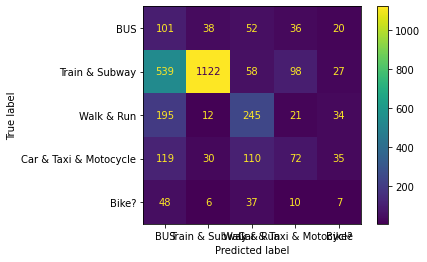

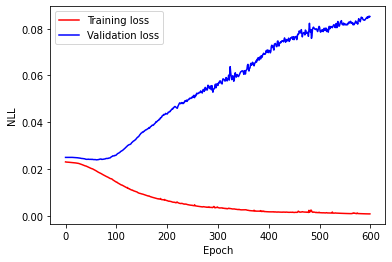

In [ ]:
batch_size = 64
num_epochs = 600
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
training_loss = []
validation_loss = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    net.train()
    for i in range(num_batches_train):
        slc = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slc]))
        # print(x_batch.shape)
        output = net(x_batch.float().cuda())
        
        # compute gradients given loss
        y_batch = Variable(torch.from_numpy(y_train[slc]).long()).reshape(-1)
        # print(output.shape, y_batch.shape)
        loss = criterion(output, y_batch.cuda())
        optimizer.zero_grad()

        # for item in net.named_parameters():
        #     h = item[1].register_hook(lambda grad: print(grad))
        loss.backward()

        # prevent gradient exploding
        torch.nn.utils.clip_grad_norm(net.parameters(), 0.25)
        optimizer.step()
        
        # Update loss
        epoch_training_loss += loss.detach().cpu().numpy()

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    with torch.no_grad(): # 禁用梯度计算
        for i in range(num_batches_train):
            slc = get_slice(i, batch_size)
            # print(slc)
            x_batch = Variable(torch.from_numpy(x_train[slc]))
            
            output = net(x_batch.float().cuda()) # [seq, batch, num_direction*hidden_size]
            # print(output.shape)
            preds = torch.max(output, 1)[1]
            # print(preds.shape)
            # print('preds:', preds)
            
            train_targs += list(y_train[slc].reshape(-1))
            train_preds += list(preds.cpu().data.numpy())

    
    ### Evaluate validation
    val_preds, val_targs = [], []
    with torch.no_grad(): # 禁用梯度计算
        for i in range(num_batches_valid):
            slc = get_slice(i, batch_size)
            x_batch = Variable(torch.from_numpy(x_valid[slc]))
            # print(x_batch)
            output = net(x_batch.float().cuda())
            # print(output)
            preds = torch.max(output, 1)[1]
            # print('preds:', preds)
            
            val_preds += list(preds.cpu().data.numpy())
            val_targs += list(y_valid[slc].reshape(-1))
            # Compute loss
            loss = criterion(output, y_batch.cuda())
            # Update loss
            epoch_validation_loss += loss.detach().cpu().numpy()

    train_acc_cur = accuracy_score(train_targs, train_preds)

    # print(val_targs)
    # print(val_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(x_train))
    validation_loss.append(epoch_validation_loss/len(x_valid))
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Validation Loss %f, Train acc %f, Valid acc %f" % (
                epoch+1, training_loss[-1], validation_loss[-1], train_acc_cur, valid_acc_cur))
        
    if epoch == num_epochs-1:
        print(val_targs, val_preds)
        cm = confusion_matrix(val_targs, val_preds, labels = [0, 1, 2, 3, 4])
        ConfusionMatrixDisplay(cm, display_labels= ['BUS','Train & Subway', 'Walk & Run', 'Car & Taxi & Motocycle', 'Bike?']).plot(values_format = 'd')
        print(classification_report(val_targs, val_preds, target_names = ['BUS','Train & Subway', 'Walk & Run', 'Car & Taxi & Motocycle', 'Bike?']))


# Plot training and validation loss
import matplotlib.pyplot as plt
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()


[0.13828125, 0.1515625, 0.16015625, 0.17109375, 0.18359375, 0.192578125, 0.199609375, 0.20859375, 0.211328125, 0.216015625, 0.216796875, 0.220703125, 0.226953125, 0.232421875, 0.238671875, 0.2390625, 0.2421875, 0.246484375, 0.248046875, 0.25, 0.25546875, 0.258984375, 0.26171875, 0.276171875, 0.28203125, 0.295703125, 0.30859375, 0.319921875, 0.32578125, 0.330859375, 0.33359375, 0.34140625, 0.341015625, 0.346875, 0.351953125, 0.360546875, 0.36328125, 0.369921875, 0.375, 0.383203125, 0.387109375, 0.391015625, 0.387109375, 0.38671875, 0.387890625, 0.39296875, 0.39375, 0.404296875, 0.40625, 0.412109375, 0.4140625, 0.41796875, 0.428515625, 0.4359375, 0.4390625, 0.439453125, 0.44296875, 0.445703125, 0.457421875, 0.459375, 0.464453125, 0.472265625, 0.483203125, 0.490234375, 0.496484375, 0.4953125, 0.498046875, 0.511328125, 0.515625, 0.51796875, 0.52265625, 0.52890625, 0.53359375, 0.537890625, 0.545703125, 0.555859375, 0.563671875, 0.56640625, 0.57109375, 0.578515625, 0.580859375, 0.58203125, 0

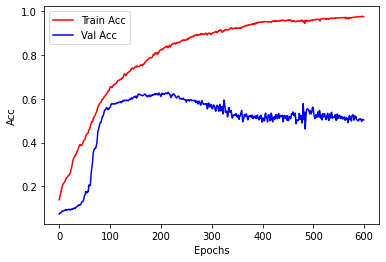


Test set Acc:  0.310096


In [ ]:
import matplotlib.pyplot as plt

epoch = np.arange(len(train_acc))
plt.figure()
print(train_acc)
print(valid_acc)
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Acc', 'Val Acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()

### Evaluate test set
x_batch = Variable(torch.from_numpy(x_test))
output = net(x_batch.float().cuda())
preds = torch.max(output, 1)[1]
print("\nTest set Acc:  %f" % (accuracy_score(list(y_test.reshape(-1)), list(preds.cpu().data.numpy()))))

## Define a Recurrent Neural Network seq_8 + BiGRU

> Indented block



In [ ]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

#from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

Build the network based on the <span class="mark">yellow colored parameters</span>

![image.png](attachment:image.png)

In [ ]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


Running GPU.


### define train, validation, test set

batch_size = 10
[12, 1, 0, 14, 6, 3, 20, 17, 16, 10, 11, 13, 21]
[5, 4, 2, 22, 15]
[18, 7, 8, 9, 19]

batch_size = 20
[9, 18, 13, 20, 1, 22, 12, 10, 17, 0, 4, 16, 21]
[11, 19, 8, 2, 5]
[15, 14, 3, 6, 7]

1. Batch size / shuffle
2. LSTM / GRU
3. Confusion Matrix



In [ ]:
np.array(x_train).shape

(74, 12, 800)

### Define Network

In [ ]:
# Hyper-parameters
input_size = 800
hidden_size = 5

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.rnn = nn.GRU(input_size, hidden_size = hidden_size, num_layers = 4, bidirectional = True, bias = False, batch_first = True ) 
        #discuss bidirectional and compare with Gru and LSTM
        self.dropout = nn.Dropout2d(p = 0.5)
        self.layernorm = nn.LayerNorm([2* hidden_size])
        self.l_out1 = nn.Linear(in_features=2*hidden_size,
                            out_features= 10,
                            bias=False)
        self.l_out2 = nn.Linear(in_features=10,
                            out_features= 5,
                            bias=False)
        

    def forward(self, x):

        # RNN returns output and last hidden state
        # print("1    ", x.shape)
        x, h = self.rnn(x)

        x = self.layernorm(x)
        # print("2    ", x.shape)
        # Flatten output for feed-forward layer
        x = relu(x.view(-1, 2 * self.rnn.hidden_size))
        # print("3    ", x.shape)
        # x = self.dropout(x)
        # Output layer
        # x = self.l_out1(x)
        x = relu(self.l_out1(x))
        # print("4    ", x.shape)
        x = relu(self.l_out2(x))

        
        return x

In [ ]:
# Initialize a new network
net = Net()
if use_cuda:
    net.cuda()
print(net)

# Define a loss function and optimizer for this problem
y_train_mode_spread = [sege for trip in y_train for sege in trip]
print(y_train_mode_spread)
unique, counts = np.unique(y_train_mode_spread, return_counts=True)
print(unique, counts)
weights = torch.FloatTensor(1/counts * np.min(counts)).cuda()
print(weights)
criterion = nn.CrossEntropyLoss(weight= weights)
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr =0.005, betas=(0.9, 0.999),eps = 1e-08, weight_decay=0.0001 ) # early stop/ auto decay
#optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=0.0001 ) # early stop/ auto decay

#ADAM lr=0.001, wc=0.0001


Net(
  (rnn): GRU(800, 5, num_layers=4, bias=False, batch_first=True, bidirectional=True)
  (dropout): Dropout2d(p=0.5, inplace=False)
  (layernorm): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
  (l_out1): Linear(in_features=10, out_features=10, bias=False)
  (l_out2): Linear(in_features=10, out_features=5, bias=False)
)
[2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [ ]:
np.sum([np.product(x.detach().cpu().numpy().shape) for x in net.parameters()])

25670

In [ ]:
np.array(x_train[4]).shape

(12, 800)

### Train the network

Epoch  1 : Train Loss 0.021884 , Validation Loss 0.019436, Train acc 0.270833, Valid acc 0.059462


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch 11 : Train Loss 0.021576 , Validation Loss 0.019403, Train acc 0.375000, Valid acc 0.103733
Epoch 21 : Train Loss 0.021244 , Validation Loss 0.019515, Train acc 0.421875, Valid acc 0.164062
Epoch 31 : Train Loss 0.020508 , Validation Loss 0.019884, Train acc 0.414062, Valid acc 0.295573
Epoch 41 : Train Loss 0.018883 , Validation Loss 0.021278, Train acc 0.437500, Valid acc 0.394531
Epoch 51 : Train Loss 0.016918 , Validation Loss 0.024153, Train acc 0.533854, Valid acc 0.378038
Epoch 61 : Train Loss 0.015031 , Validation Loss 0.027429, Train acc 0.589844, Valid acc 0.314236
Epoch 71 : Train Loss 0.013163 , Validation Loss 0.031886, Train acc 0.621094, Valid acc 0.236111
Epoch 81 : Train Loss 0.011729 , Validation Loss 0.038111, Train acc 0.694010, Valid acc 0.230903
Epoch 91 : Train Loss 0.010537 , Validation Loss 0.044009, Train acc 0.753906, Valid acc 0.213976
Epoch 101 : Train Loss 0.009744 , Validation Loss 0.049931, Train acc 0.786458, Valid acc 0.207465
Epoch 111 : Train L

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


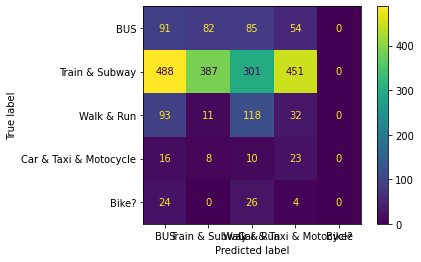

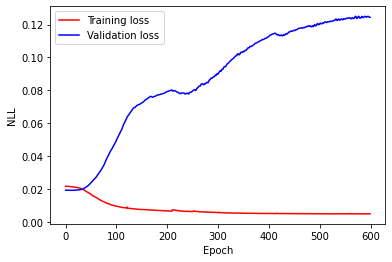

In [ ]:
batch_size = 64
num_epochs = 600
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
training_loss = []
validation_loss = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    net.train()
    for i in range(num_batches_train):
        slc = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slc]))
        # print(x_batch.shape)
        output = net(x_batch.float().cuda())
        
        # compute gradients given loss
        y_batch = Variable(torch.from_numpy(y_train[slc]).long()).reshape(-1)
        # print(output.shape, y_batch.shape)
        loss = criterion(output, y_batch.cuda())
        optimizer.zero_grad()

        # for item in net.named_parameters():
        #     h = item[1].register_hook(lambda grad: print(grad))
        loss.backward()

        # prevent gradient exploding
        torch.nn.utils.clip_grad_norm(net.parameters(), 0.25)
        optimizer.step()
        
        # Update loss
        epoch_training_loss += loss.detach().cpu().numpy()

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    with torch.no_grad(): # 禁用梯度计算
        for i in range(num_batches_train):
            slc = get_slice(i, batch_size)
            # print(slc)
            x_batch = Variable(torch.from_numpy(x_train[slc]))
            
            output = net(x_batch.float().cuda()) # [seq, batch, num_direction*hidden_size]
            # print(output.shape)
            preds = torch.max(output, 1)[1]
            # print(preds.shape)
            # print('preds:', preds)
            
            train_targs += list(y_train[slc].reshape(-1))
            train_preds += list(preds.cpu().data.numpy())

    
    ### Evaluate validation
    val_preds, val_targs = [], []
    with torch.no_grad(): # 禁用梯度计算
        for i in range(num_batches_valid):
            slc = get_slice(i, batch_size)
            x_batch = Variable(torch.from_numpy(x_valid[slc]))
            # print(x_batch)
            output = net(x_batch.float().cuda())
            # print(output)
            preds = torch.max(output, 1)[1]
            # print('preds:', preds)
            
            val_preds += list(preds.cpu().data.numpy())
            val_targs += list(y_valid[slc].reshape(-1))
            # Compute loss
            loss = criterion(output, y_batch.cuda())
            # Update loss
            epoch_validation_loss += loss.detach().cpu().numpy()

    train_acc_cur = accuracy_score(train_targs, train_preds)

    # print(val_targs)
    # print(val_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(x_train))
    validation_loss.append(epoch_validation_loss/len(x_valid))
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Validation Loss %f, Train acc %f, Valid acc %f" % (
                epoch+1, training_loss[-1], validation_loss[-1], train_acc_cur, valid_acc_cur))
        
    if epoch == num_epochs-1:
        print(val_targs, val_preds)
        cm = confusion_matrix(val_targs, val_preds, labels = [0, 1, 2, 3, 4])
        ConfusionMatrixDisplay(cm, display_labels= ['BUS','Train & Subway', 'Walk & Run', 'Car & Taxi & Motocycle', 'Bike?']).plot(values_format = 'd')
        print(classification_report(val_targs, val_preds, target_names = ['BUS','Train & Subway', 'Walk & Run', 'Car & Taxi & Motocycle', 'Bike?']))


# Plot training and validation loss
import matplotlib.pyplot as plt
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()


[0.2708333333333333, 0.2864583333333333, 0.3098958333333333, 0.3229166666666667, 0.3359375, 0.34765625, 0.35546875, 0.3619791666666667, 0.3723958333333333, 0.3658854166666667, 0.375, 0.3736979166666667, 0.3776041666666667, 0.37890625, 0.38671875, 0.3893229166666667, 0.40234375, 0.4088541666666667, 0.4153645833333333, 0.4166666666666667, 0.421875, 0.4205729166666667, 0.4192708333333333, 0.41796875, 0.42578125, 0.4140625, 0.4075520833333333, 0.4231770833333333, 0.4192708333333333, 0.4192708333333333, 0.4140625, 0.41796875, 0.4088541666666667, 0.4114583333333333, 0.4088541666666667, 0.4114583333333333, 0.4140625, 0.4192708333333333, 0.4153645833333333, 0.421875, 0.4375, 0.4596354166666667, 0.4713541666666667, 0.484375, 0.4921875, 0.5013020833333334, 0.5052083333333334, 0.51171875, 0.515625, 0.5247395833333334, 0.5338541666666666, 0.5338541666666666, 0.5403645833333334, 0.5416666666666666, 0.5533854166666666, 0.5716145833333334, 0.578125, 0.5768229166666666, 0.5872395833333334, 0.58984375,

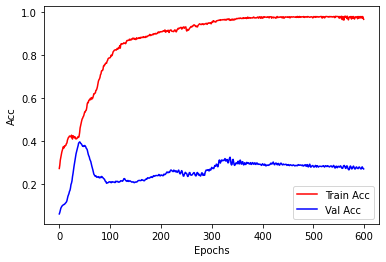


Test set Acc:  0.330882


In [ ]:
import matplotlib.pyplot as plt

epoch = np.arange(len(train_acc))
plt.figure()
print(train_acc)
print(valid_acc)
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Acc', 'Val Acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()

### Evaluate test set
x_batch = Variable(torch.from_numpy(x_test))
output = net(x_batch.float().cuda())
preds = torch.max(output, 1)[1]
print("\nTest set Acc:  %f" % (accuracy_score(list(y_test.reshape(-1)), list(preds.cpu().data.numpy()))))

## Define a Recurrent Neural Network seq_10

In [ ]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

#from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

Build the network based on the <span class="mark">yellow colored parameters</span>

![image.png](attachment:image.png)

In [ ]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


Running GPU.


### define train, validation, test set

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# split to train, valid, test set
x_remain_ind, x_test_ind, y_remain_ind, y_test_ind = train_test_split(list(range(len(userRNN10))),list(range(len(labelRNN10))),test_size=0.2, random_state = 1)
x_train_ind, x_valid_ind, y_train_ind, y_valid_ind = train_test_split(x_remain_ind,y_remain_ind,test_size =0.375, random_state = 1)

print(x_train_ind)
print(x_valid_ind)
print(x_test_ind)
print(y_train_ind)
print(y_valid_ind)
print(y_test_ind)

print(f'We have {len(x_train_ind)} users in the training set')
print(f'We have {len(x_valid_ind)} users in the validation set.')

def flatten_user_channel(x):
    return [[[c for p in sege for c in p] for sege in trip] for user in x for trip in user]
def flatten_user(x):
    return [trip for user in x for trip in user]

print(f'We have {len(x_test_ind)} users in the test set.')
x_train =np.array(flatten_user_channel([userRNN10[i] for i in x_train_ind]))
x_valid = np.array(flatten_user_channel([userRNN10[i] for i in x_valid_ind]))
x_test = np.array(flatten_user_channel([userRNN10[i] for i in x_test_ind]))

y_train = np.array(flatten_user([labelRNN10[i] for i in y_train_ind]))
y_valid = np.array(flatten_user([labelRNN10[i] for i in y_valid_ind]))
y_test = np.array(flatten_user([labelRNN10[i] for i in y_test_ind]))

print("Total segments of x_train",sum([np.array(i).shape[0] for i in x_train]), "*",  np.array(x_train[0]).shape)
print("Total segments of y_train",sum([np.array(i).shape[0] for i in y_train]), "*", np.array(y_train[0]).shape)

print("Total segments of x_valid",sum([np.array(i).shape[0] for i in x_valid]), "*",  np.array(x_valid[0]).shape)
print("Total segments of y_valid",sum([np.array(i).shape[0] for i in y_valid]),"*", np.array(y_valid[0]).shape)

print("Total segments of x_test",sum([np.array(i).shape[0] for i in x_test]), "*",  np.array(x_test[0]).shape)
print("Total segments of y_test",sum([np.array(i).shape[0] for i in y_test]), "*", np.array(y_test[0]).shape)

[9, 6, 18, 10, 15, 22, 5, 11, 7, 13, 16, 1, 23]
[12, 26, 4, 0, 8, 27, 25, 2, 21]
[24, 17, 19, 20, 14, 3]
[9, 6, 18, 10, 15, 22, 5, 11, 7, 13, 16, 1, 23]
[12, 26, 4, 0, 8, 27, 25, 2, 21]
[24, 17, 19, 20, 14, 3]
We have 13 users in the training set
We have 9 users in the validation set.
We have 6 users in the test set.
Total segments of x_train 2110 * (10, 800)
Total segments of y_train 2110 * (10,)
Total segments of x_valid 2780 * (10, 800)
Total segments of y_valid 2780 * (10,)
Total segments of x_test 300 * (10, 800)
Total segments of y_test 300 * (10,)


batch_size = 10
[12, 1, 0, 14, 6, 3, 20, 17, 16, 10, 11, 13, 21]
[5, 4, 2, 22, 15]
[18, 7, 8, 9, 19]

batch_size = 20
[9, 18, 13, 20, 1, 22, 12, 10, 17, 0, 4, 16, 21]
[11, 19, 8, 2, 5]
[15, 14, 3, 6, 7]

1. Batch size / shuffle
2. LSTM / GRU
3. Confusion Matrix



In [ ]:
np.array(x_train).shape

(211, 10, 800)

### Define Network

In [ ]:
# Hyper-parameters
input_size = 800
hidden_size = 5

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.rnn = nn.LSTM(input_size, hidden_size = hidden_size, num_layers = 3, bidirectional = True, bias = False, batch_first = True ) 
        #discuss bidirectional and compare with Gru and LSTM
        self.dropout = nn.Dropout2d(p = 0.7)
        self.layernorm = nn.LayerNorm([2* hidden_size])
        self.l_out1 = nn.Linear(in_features=2*hidden_size,
                            out_features= 10,
                            bias=False)
        self.l_out2 = nn.Linear(in_features=10,
                            out_features= 5,
                            bias=False)
    def forward(self, x):

        # RNN returns output and last hidden state
        # print("1    ", x.shape)
        x, h = self.rnn(x)

        x = self.layernorm(x)
        # print("2    ", x.shape)
        # Flatten output for feed-forward layer
        x = relu(x.view(-1, 2 * self.rnn.hidden_size))
        # print("3    ", x.shape)
        # x = self.dropout(x)
        # Output layer
        # x = self.l_out1(x)
        x = relu(self.l_out1(x))
        # print("4    ", x.shape)
        x = relu(self.l_out2(x))


        
        return x

In [ ]:
# Initialize a new network
net = Net()
if use_cuda:
    net.cuda()
print(net)

# Define a loss function and optimizer for this problem
y_train_mode_spread = [sege for trip in y_train for sege in trip]
print(y_train_mode_spread)
unique, counts = np.unique(y_train_mode_spread, return_counts=True)
print(unique, counts)
weights = torch.FloatTensor(1/counts * np.min(counts)).cuda()
print(weights)
criterion = nn.CrossEntropyLoss(weight= weights)
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr =0.001, betas=(0.9, 0.999),eps = 1e-08, weight_decay=0.0001 ) # early stop/ auto decay
#optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=0.0001 ) # early stop/ auto decay

#ADAM lr=0.001, wc=0.0001


Net(
  (rnn): LSTM(800, 5, num_layers=3, bias=False, batch_first=True, bidirectional=True)
  (dropout): Dropout2d(p=0.7, inplace=False)
  (layernorm): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
  (l_out1): Linear(in_features=10, out_features=10, bias=False)
  (l_out2): Linear(in_features=10, out_features=5, bias=False)
)
[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 2.0, 2

In [ ]:
np.sum([np.product(x.detach().cpu().numpy().shape) for x in net.parameters()])

33570

In [ ]:
np.array(x_train[4]).shape

(10, 800)

### define criterion

In [ ]:
print(x_valid)

[[[1.87423161e-02 3.74846321e-03 7.49692642e-04 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.64183353e-03
   5.28366706e-04 2.44447867e+01]
  [6.69010855e-02 2.23003618e-02 7.43345395e-03 ... 1.61357045e-02
   8.06785227e-03 3.01248839e+02]
  ...
  [4.53394831e-02 2.26697416e-02 1.13348708e-02 ... 2.43394270e-02
   1.21697135e-02 1.32061158e+01]
  [3.84802615e-02 1.92401308e-02 9.62006538e-03 ... 5.71624299e-03
   2.85812150e-03 1.43105294e+02]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.15673292e-02
   5.78366458e-03 9.98965048e+01]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.18218704e-01
   5.91093522e-02 2.52346439e+00]
  [2.26919434e-01 1.13459717e-01 5.67298585e-02 ... 1.26303958e-01
   6.31519788e-02 1.52702288e+01]
  [2.44525217e-01 1.22262608e-01 6.11313042e-02 ... 6.88113799e-02
   1.37622760e-02 2.16665485e+00]
  ...
  [4.04441073e-01 8.08882145e-02 1.61776429e-02 ... 9.36453783e-02
   1.87290

### Train the network

Epoch  1 : Train Loss 0.007589 , Validation Loss 0.011526, Train acc 0.173437, Valid acc 0.210156


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch 11 : Train Loss 0.007465 , Validation Loss 0.011495, Train acc 0.195312, Valid acc 0.128125
Epoch 21 : Train Loss 0.007367 , Validation Loss 0.011484, Train acc 0.208594, Valid acc 0.102344
Epoch 31 : Train Loss 0.007263 , Validation Loss 0.011470, Train acc 0.226562, Valid acc 0.153516
Epoch 41 : Train Loss 0.007130 , Validation Loss 0.011448, Train acc 0.247656, Valid acc 0.224219
Epoch 51 : Train Loss 0.006976 , Validation Loss 0.011459, Train acc 0.282813, Valid acc 0.321094
Epoch 61 : Train Loss 0.006805 , Validation Loss 0.011479, Train acc 0.313281, Valid acc 0.371875
Epoch 71 : Train Loss 0.006627 , Validation Loss 0.011500, Train acc 0.361719, Valid acc 0.453906
Epoch 81 : Train Loss 0.006425 , Validation Loss 0.011529, Train acc 0.412500, Valid acc 0.508594
Epoch 91 : Train Loss 0.006205 , Validation Loss 0.011591, Train acc 0.457031, Valid acc 0.539453
Epoch 101 : Train Loss 0.005977 , Validation Loss 0.011639, Train acc 0.485156, Valid acc 0.560547
Epoch 111 : Train L

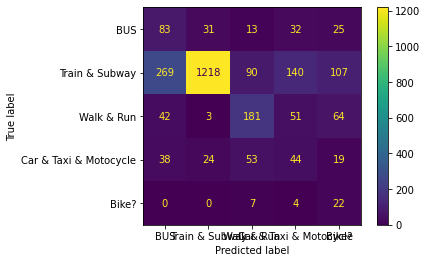

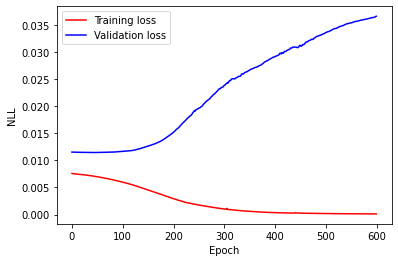

In [ ]:
batch_size = 128
num_epochs = 600
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
training_loss = []
validation_loss = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    net.train()
    for i in range(num_batches_train):
        slc = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slc]))
        # print(x_batch.shape)
        output = net(x_batch.float().cuda())
        
        # compute gradients given loss
        y_batch = Variable(torch.from_numpy(y_train[slc]).long()).reshape(-1)
        # print(output.shape, y_batch.shape)
        loss = criterion(output, y_batch.cuda())
        optimizer.zero_grad()

        # for item in net.named_parameters():
        #     h = item[1].register_hook(lambda grad: print(grad))
        loss.backward()

        # prevent gradient exploding
        torch.nn.utils.clip_grad_norm(net.parameters(), 0.25)
        optimizer.step()
        
        # Update loss
        epoch_training_loss += loss.detach().cpu().numpy()

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    with torch.no_grad(): # 禁用梯度计算
        for i in range(num_batches_train):
            slc = get_slice(i, batch_size)
            # print(slc)
            x_batch = Variable(torch.from_numpy(x_train[slc]))
            
            output = net(x_batch.float().cuda()) # [seq, batch, num_direction*hidden_size]
            # print(output.shape)
            preds = torch.max(output, 1)[1]
            # print(preds.shape)
            # print('preds:', preds)
            
            train_targs += list(y_train[slc].reshape(-1))
            train_preds += list(preds.cpu().data.numpy())

    
    ### Evaluate validation
    val_preds, val_targs = [], []
    with torch.no_grad(): # 禁用梯度计算
        for i in range(num_batches_valid):
            slc = get_slice(i, batch_size)
            x_batch = Variable(torch.from_numpy(x_valid[slc]))
            # print(x_batch)
            output = net(x_batch.float().cuda())
            # print(output)
            preds = torch.max(output, 1)[1]
            # print('preds:', preds)
            
            val_preds += list(preds.cpu().data.numpy())
            val_targs += list(y_valid[slc].reshape(-1))
            # Compute loss
            loss = criterion(output, y_batch.cuda())
            # Update loss
            epoch_validation_loss += loss.detach().cpu().numpy()

    train_acc_cur = accuracy_score(train_targs, train_preds)

    # print(val_targs)
    # print(val_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(x_train))
    validation_loss.append(epoch_validation_loss/len(x_valid))
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Validation Loss %f, Train acc %f, Valid acc %f" % (
                epoch+1, training_loss[-1], validation_loss[-1], train_acc_cur, valid_acc_cur))
        
    if epoch == num_epochs-1:
        print(val_targs, val_preds)
        cm = confusion_matrix(val_targs, val_preds, labels = [0, 1, 2, 3, 4])
        ConfusionMatrixDisplay(cm, display_labels= ['BUS','Train & Subway', 'Walk & Run', 'Car & Taxi & Motocycle', 'Bike?']).plot(values_format = 'd')
        print(classification_report(val_targs, val_preds, target_names = ['BUS','Train & Subway', 'Walk & Run', 'Car & Taxi & Motocycle', 'Bike?']))


# Plot training and validation loss
import matplotlib.pyplot as plt
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()


[0.1734375, 0.17890625, 0.1890625, 0.18671875, 0.1953125, 0.19296875, 0.19296875, 0.1921875, 0.19140625, 0.1953125, 0.1953125, 0.19609375, 0.19609375, 0.1984375, 0.203125, 0.203125, 0.21171875, 0.2140625, 0.209375, 0.21015625, 0.20859375, 0.2125, 0.21015625, 0.2109375, 0.2140625, 0.2171875, 0.21640625, 0.2171875, 0.2203125, 0.22265625, 0.2265625, 0.23046875, 0.23125, 0.2328125, 0.2359375, 0.2421875, 0.24453125, 0.24609375, 0.246875, 0.24609375, 0.24765625, 0.2484375, 0.253125, 0.25390625, 0.2578125, 0.26328125, 0.26953125, 0.271875, 0.275, 0.27734375, 0.2828125, 0.28359375, 0.28671875, 0.2890625, 0.2890625, 0.2953125, 0.29765625, 0.3, 0.3015625, 0.30546875, 0.31328125, 0.3171875, 0.31875, 0.3296875, 0.33515625, 0.3390625, 0.34375, 0.353125, 0.35859375, 0.36171875, 0.36171875, 0.365625, 0.371875, 0.3796875, 0.3875, 0.3890625, 0.39375, 0.40234375, 0.4046875, 0.4078125, 0.4125, 0.41796875, 0.421875, 0.4234375, 0.42890625, 0.43515625, 0.43984375, 0.4421875, 0.44765625, 0.453125, 0.45703125

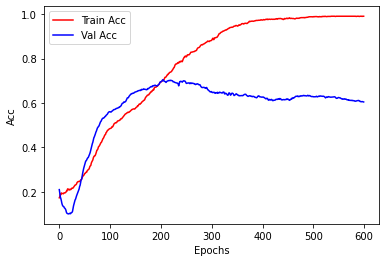


Test set Acc:  0.356667


In [ ]:
import matplotlib.pyplot as plt

epoch = np.arange(len(train_acc))
plt.figure()
print(train_acc)
print(valid_acc)
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Acc', 'Val Acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()

### Evaluate test set
x_batch = Variable(torch.from_numpy(x_test))
output = net(x_batch.float().cuda())
preds = torch.max(output, 1)[1]
print("\nTest set Acc:  %f" % (accuracy_score(list(y_test.reshape(-1)), list(preds.cpu().data.numpy()))))

## Define a Recurrent Neural Network seq_12

In [ ]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

#from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

Build the network based on the <span class="mark">yellow colored parameters</span>

![image.png](attachment:image.png)

In [ ]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


Running GPU.


### define train, validation, test set

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# split to train, valid, test set
x_remain_ind, x_test_ind, y_remain_ind, y_test_ind = train_test_split(list(range(len(userRNN12))),list(range(len(labelRNN12))),test_size=0.2, random_state = 1)
x_train_ind, x_valid_ind, y_train_ind, y_valid_ind = train_test_split(x_remain_ind,y_remain_ind,test_size =0.375, random_state = 1)

print(x_train_ind)
print(x_valid_ind)
print(x_test_ind)
print(y_train_ind)
print(y_valid_ind)
print(y_test_ind)

print(f'We have {len(x_train_ind)} users in the training set')
print(f'We have {len(x_valid_ind)} users in the validation set.')

def flatten_user_channel(x):
    return [[[c for p in sege for c in p] for sege in trip] for user in x for trip in user]
def flatten_user(x):
    return [trip for user in x for trip in user]

print(f'We have {len(x_test_ind)} users in the test set.')
x_train =np.array(flatten_user_channel([userRNN12[i] for i in x_train_ind]))
x_valid = np.array(flatten_user_channel([userRNN12[i] for i in x_valid_ind]))
x_test = np.array(flatten_user_channel([userRNN12[i] for i in x_test_ind]))

y_train = np.array(flatten_user([labelRNN12[i] for i in y_train_ind]))
y_valid = np.array(flatten_user([labelRNN12[i] for i in y_valid_ind]))
y_test = np.array(flatten_user([labelRNN12[i] for i in y_test_ind]))

print("Total segments of x_train",sum([np.array(i).shape[0] for i in x_train]), "*",  np.array(x_train[0]).shape)
print("Total segments of y_train",sum([np.array(i).shape[0] for i in y_train]), "*", np.array(y_train[0]).shape)

print("Total segments of x_valid",sum([np.array(i).shape[0] for i in x_valid]), "*",  np.array(x_valid[0]).shape)
print("Total segments of y_valid",sum([np.array(i).shape[0] for i in y_valid]),"*", np.array(y_valid[0]).shape)

print("Total segments of x_test",sum([np.array(i).shape[0] for i in x_test]), "*",  np.array(x_test[0]).shape)
print("Total segments of y_test",sum([np.array(i).shape[0] for i in y_test]), "*", np.array(y_test[0]).shape)

[21, 10, 22, 17, 5, 11, 16, 1, 23, 15, 6]
[2, 8, 7, 0, 4, 9, 19, 12]
[13, 18, 3, 14, 20]
[21, 10, 22, 17, 5, 11, 16, 1, 23, 15, 6]
[2, 8, 7, 0, 4, 9, 19, 12]
[13, 18, 3, 14, 20]
We have 11 users in the training set
We have 8 users in the validation set.
We have 5 users in the test set.
Total segments of x_train 888 * (12, 800)
Total segments of y_train 888 * (12,)
Total segments of x_valid 3000 * (12, 800)
Total segments of y_valid 3000 * (12,)
Total segments of x_test 408 * (12, 800)
Total segments of y_test 408 * (12,)


batch_size = 10
[12, 1, 0, 14, 6, 3, 20, 17, 16, 10, 11, 13, 21]
[5, 4, 2, 22, 15]
[18, 7, 8, 9, 19]

batch_size = 20
[9, 18, 13, 20, 1, 22, 12, 10, 17, 0, 4, 16, 21]
[11, 19, 8, 2, 5]
[15, 14, 3, 6, 7]

1. Batch size / shuffle
2. LSTM / GRU
3. Confusion Matrix



In [ ]:
np.array(x_train).shape

(74, 12, 800)

### Define Network

In [ ]:
# Hyper-parameters
input_size = 800
hidden_size = 5

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.rnn = nn.LSTM(input_size, hidden_size = hidden_size, num_layers = 3, bidirectional = True, bias = False, batch_first = True ) 
        #discuss bidirectional and compare with Gru and LSTM
        self.dropout = nn.Dropout2d(p = 0.7)
        self.layernorm = nn.LayerNorm([2* hidden_size])
        self.l_out1 = nn.Linear(in_features=2*hidden_size,
                            out_features= 10,
                            bias=False)
        self.l_out2 = nn.Linear(in_features=10,
                            out_features= 5,
                            bias=False)

    def forward(self, x):

        # RNN returns output and last hidden state
        # print("1    ", x.shape)
        x, h = self.rnn(x)

        x = self.layernorm(x)
        # print("2    ", x.shape)
        # Flatten output for feed-forward layer
        x = relu(x.view(-1, 2 * self.rnn.hidden_size))
        # print("3    ", x.shape)
        # x = self.dropout(x)
        # Output layer
        # x = self.l_out1(x)
        x = relu(self.l_out1(x))
        # print("4    ", x.shape)
        x = relu(self.l_out2(x))

        
        return x

In [ ]:
# Initialize a new network
net = Net()
if use_cuda:
    net.cuda()
print(net)

# Define a loss function and optimizer for this problem
y_train_mode_spread = [sege for trip in y_train for sege in trip]
print(y_train_mode_spread)
unique, counts = np.unique(y_train_mode_spread, return_counts=True)
print(unique, counts)
weights = torch.FloatTensor(1/counts * np.min(counts)).cuda()
print(weights)
criterion = nn.CrossEntropyLoss(weight= weights)
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr =0.001, betas=(0.9, 0.999),eps = 1e-08, weight_decay=0.0001 ) # early stop/ auto decay
#optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=0.0001 ) # early stop/ auto decay

#ADAM lr=0.001, wc=0.0001


Net(
  (rnn): LSTM(800, 5, num_layers=3, bias=False, batch_first=True, bidirectional=True)
  (dropout): Dropout2d(p=0.7, inplace=False)
  (layernorm): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
  (l_out1): Linear(in_features=10, out_features=10, bias=False)
  (l_out2): Linear(in_features=10, out_features=5, bias=False)
)
[2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [ ]:
np.sum([np.product(x.detach().cpu().numpy().shape) for x in net.parameters()])

33570

In [ ]:
np.array(x_train[4]).shape

(12, 800)

### Train the network

In [ ]:
batch_size = 128
num_epochs = 600
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
training_loss = []
validation_loss = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    net.train()
    for i in range(num_batches_train):
        slc = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slc]))
        # print(x_batch.shape)
        output = net(x_batch.float().cuda())
        
        # compute gradients given loss
        y_batch = Variable(torch.from_numpy(y_train[slc]).long()).reshape(-1)
        # print(output.shape, y_batch.shape)
        loss = criterion(output, y_batch.cuda())
        optimizer.zero_grad()

        # for item in net.named_parameters():
        #     h = item[1].register_hook(lambda grad: print(grad))
        loss.backward()

        # prevent gradient exploding
        torch.nn.utils.clip_grad_norm(net.parameters(), 0.25)
        optimizer.step()
        
        # Update loss
        epoch_training_loss += loss.detach().cpu().numpy()

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    with torch.no_grad(): # 禁用梯度计算
        for i in range(num_batches_train):
            slc = get_slice(i, batch_size)
            # print(slc)
            x_batch = Variable(torch.from_numpy(x_train[slc]))
            
            output = net(x_batch.float().cuda()) # [seq, batch, num_direction*hidden_size]
            # print(output.shape)
            preds = torch.max(output, 1)[1]
            # print(preds.shape)
            # print('preds:', preds)
            
            train_targs += list(y_train[slc].reshape(-1))
            train_preds += list(preds.cpu().data.numpy())

    
    ### Evaluate validation
    val_preds, val_targs = [], []
    with torch.no_grad(): # 禁用梯度计算
        for i in range(num_batches_valid):
            slc = get_slice(i, batch_size)
            x_batch = Variable(torch.from_numpy(x_valid[slc]))
            # print(x_batch)
            output = net(x_batch.float().cuda())
            # print(output)
            preds = torch.max(output, 1)[1]
            # print('preds:', preds)
            
            val_preds += list(preds.cpu().data.numpy())
            val_targs += list(y_valid[slc].reshape(-1))
            # Compute loss
            loss = criterion(output, y_batch .cuda())
            # Update loss
            epoch_validation_loss += loss.detach().cpu().numpy()

    train_acc_cur = accuracy_score(train_targs, train_preds)

    # print(val_targs)
    # print(val_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(x_train))
    validation_loss.append(epoch_validation_loss/len(x_valid))
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Validation Loss %f, Train acc %f, Valid acc %f" % (
                epoch+1, training_loss[-1], validation_loss[-1], train_acc_cur, valid_acc_cur))
        
    if epoch == num_epochs-1:
        print(val_targs, val_preds)
        cm = confusion_matrix(val_targs, val_preds, labels = [0, 1, 2, 3, 4])
        ConfusionMatrixDisplay(cm, display_labels= ['BUS','Train & Subway', 'Walk & Run', 'Car & Taxi & Motocycle', 'Bike?']).plot(values_format = 'd')
        print(classification_report(val_targs, val_preds, target_names = ['BUS','Train & Subway', 'Walk & Run', 'Car & Taxi & Motocycle', 'Bike?']))


# Plot training and validation loss
import matplotlib.pyplot as plt
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()


ValueError: ignored

In [ ]:
import matplotlib.pyplot as plt

epoch = np.arange(len(train_acc))
plt.figure()
print(train_acc)
print(valid_acc)
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Acc', 'Val Acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()

### Evaluate test set
x_batch = Variable(torch.from_numpy(x_test))
output = net(x_batch.float().cuda())
preds = torch.max(output, 1)[1]
print("\nTest set Acc:  %f" % (accuracy_score(list(y_test.reshape(-1)), list(preds.cpu().data.numpy()))))